# GMT mapping function for the past 

TO DO:
- this method of GMT mapping is extremely jumpy, probably need to use a different method! see below, 1800s are mapped to 1950s. 
- check with Wim proper GMT mapping method (see Luke's code) or use a different method for the past that will be more stable, like a shift-fit

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl?, cartopy?

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import netCDF4
import time
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

# My settings and functions
from settings import *
start_message() 

from functions import *
print(datetime.now(), 'fxns imported')

/apps/brussel/RL8/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


settings loaded
flags: {'models': 'ISIMIP3b', 'metric': 'TX99', 'method': 'empirical_percentile', 'var': 'tasmax'}
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir: none
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: none
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures
start_pi: 1850
end_pi: 1900
target_years: 2022
observed_warming_path: ../../data/gmst/gmst-obs/forster2023/decadal_averages.csv
dir_gmst_models: ../../data/gmst/gmst-models-isimip3b
2024-03-28 12:59:06.643623 fxns imported


In [2]:
%matplotlib inline

In [3]:
df_gmst_mod = merge_model_gmst(GCMs, dir_gmst_models)
df_gmst_mod

,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
year,,,,,,
1850,0.096275,0.07598,-0.094941,-0.184196,-0.068196,0.062608
1851,-0.149725,0.03998,-0.151941,-0.016196,-0.095196,0.087608
1852,-0.101725,0.00998,0.027059,-0.032196,-0.079196,0.021608
1853,0.038275,0.03198,0.061059,0.036804,-0.019196,-0.052392
1854,-0.075725,0.03098,-0.113941,0.107804,0.191804,-0.107392
...,...,...,...,...,...,...
2096,6.090275,4.75998,3.465059,5.281804,3.370804,3.743608
2097,6.278275,4.75398,3.466059,5.512804,3.036804,3.795608
2098,6.364275,4.95798,3.442059,5.356804,3.112804,3.624608


In [4]:

# annual obs warming
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]

# decadal avg obs warming
df_gmst_obs_decadal = pd.read_csv(observed_warming_path).rename(
    columns={'timebound_upper':'year'}).set_index('year')[['gmst']]
df_gmst_obs_decadal.index = df_gmst_obs_decadal.index-1

df_gmst_obs_decadal

,gmst
year,
1859,0.008113
1860,0.007613
1861,-0.007637
1862,-0.031887
1863,-0.037137
...,...
2018,1.044113
2019,1.074113
2020,1.100363


In [5]:
# extend obs annual for future 15 years for SR1.5 method

def fit_trend(data, var):
    x=data.index
    y=data[var]
    fit=sm.OLS(y, sm.add_constant(x)).fit()    
    return fit, x, y

fit, x, y = fit_trend(df_gmst_obs_annual[-15:], 'gmst')
fit.params

const   -52.941334
x1        0.026804
dtype: float64

In [6]:
x_fut = np.arange(2023,2023+14)
x_fut = sm.add_constant(x_fut)
predictions = fit.predict(x_fut)
predictions

array([1.28229132, 1.30909489, 1.33589846, 1.36270203, 1.3895056 ,
       1.41630917, 1.44311275, 1.46991632, 1.49671989, 1.52352346,
       1.55032703, 1.5771306 , 1.60393417, 1.63073774])

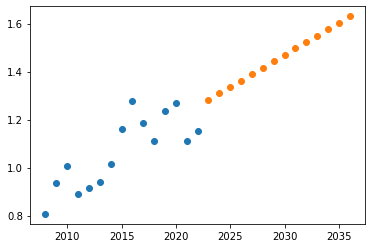

In [7]:
plt.scatter(df_gmst_obs_annual[-15:].index, df_gmst_obs_annual[-15:])
plt.scatter(x_fut[:,1], predictions)

In [8]:
df_gmst_obs_annual_ext = pd.concat([df_gmst_obs_annual, pd.DataFrame({'year':x_fut[:,1].astype(int), 'gmst': predictions}).set_index('year')])


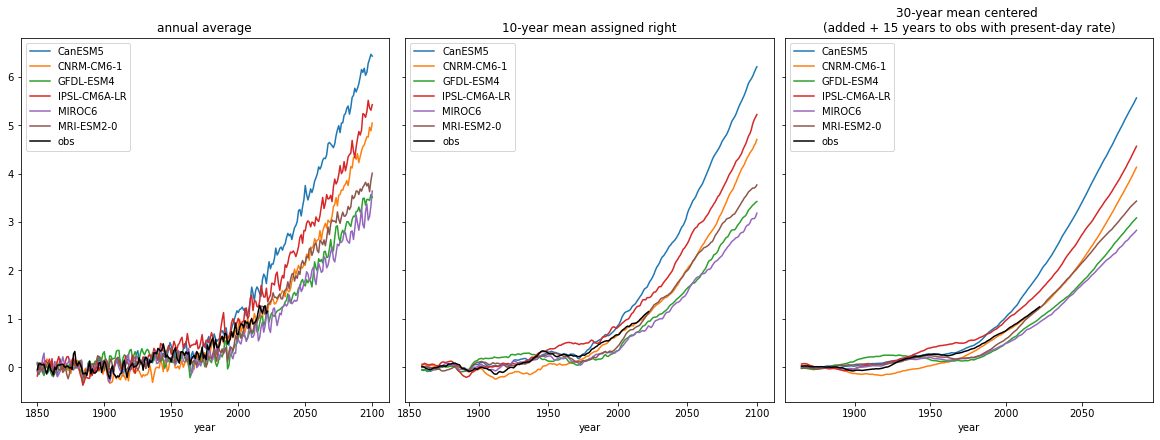

In [9]:
fig,axes=plt.subplots(1,3,figsize=(16,6), sharey=True, layout='constrained')

ax=axes[0]
df_gmst_mod.plot(ax=ax)
df_gmst_obs_annual['gmst'].plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('annual average')

ax=axes[1]
df_gmst_mod.rolling(10, min_periods=10, center=False).mean().plot(ax=ax)
df_gmst_obs_annual['gmst'].rolling(10, min_periods=10, center=False).mean().plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('10-year mean assigned right')

ax=axes[2]
df_gmst_mod.rolling(30, min_periods=30, center=True).mean().plot(ax=ax)
df_gmst_obs_annual_ext['gmst'].rolling(30, min_periods=30, center=True).mean().plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('30-year mean centered \n(added + 15 years to obs with present-day rate)');


In [10]:
df_gmst_obs_annual_ext['gmst'].rolling(30, min_periods=30, center=True).mean().dropna()

# 1.24 not 1.26 like in paper? I think the "present rate of warming" is modelled differently... look into this a little bit... 

year
1865    0.020279
1866    0.023029
1867    0.024779
1868    0.023946
1869    0.022196
          ...   
2018    1.151544
2019    1.173660
2020    1.199169
2021    1.220654
2022    1.244617
Name: gmst, Length: 158, dtype: float64

In [11]:
da_gmt_mapping_ar6_1 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='ar6',
                                          min_periods=1,
                                          flatten=False)

da_gmt_mapping_ar6_10 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='ar6',
                                          min_periods=10,
                                          flatten=False)

da_gmt_mapping_30y = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='30-yr',
                                          min_periods=30,
                                          flatten=False)

In [69]:
da_gmt_mapping_30y.sel(model=GCMs[0]).to_pandas()

feature,year_mod,temp
year,,
1875,1894,0.018008
1876,1894,0.018008
1877,1894,0.018008
1878,1880,0.007641
1879,1880,0.007641
...,...,...
2018,1999,1.004008
2019,2000,1.041475
2020,2001,1.075908


In [13]:
df_gmt_mapping_ar6_1 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='ar6',
                                          min_periods=1,
                                          flatten=True)

df_gmt_mapping_ar6_10 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='ar6',
                                          min_periods=10,
                                          flatten=True)

df_gmt_mapping_30y_30 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='30-yr',
                                          min_periods=30,
                                          flatten=True)

df_gmt_mapping_30y_1 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='30-yr',
                                          min_periods=1,
                                          flatten=True)

In [16]:
df_gmt_mapping_ar6_1

feature,temp_obs,year_CanESM5,temp_CanESM5,year_CNRM-CM6-1,temp_CNRM-CM6-1,year_GFDL-ESM4,temp_GFDL-ESM4,year_IPSL-CM6A-LR,temp_IPSL-CM6A-LR,year_MIROC6,temp_MIROC6,year_MRI-ESM2-0,temp_MRI-ESM2-0
year,,,,,,,,,,,,,
1859,0.008113,1886,0.005775,1870,0.00738,1876,0.008059,1909,0.007104,1916,0.008104,1882,0.010108
1860,0.007613,1886,0.005775,1870,0.00738,1876,0.008059,1909,0.007104,1916,0.008104,1882,0.010108
1861,-0.007637,1872,-0.010925,1887,-0.00652,1872,-0.002641,1855,-0.009029,1884,-0.007596,1862,-0.008192
1862,-0.031887,1868,-0.034225,1902,-0.03322,1853,-0.039691,1884,-0.020996,1885,-0.030696,1888,-0.030492
1863,-0.037137,1894,-0.037825,1902,-0.03322,1853,-0.039691,1853,-0.048946,1868,-0.038396,1889,-0.034792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,1.044113,2003,1.036675,2020,1.05148,2028,1.038959,2009,1.058504,2033,1.041404,2020,1.038408
2019,1.074113,2004,1.085475,2021,1.08708,2029,1.069159,2009,1.058504,2034,1.096404,2021,1.076008
2020,1.100363,2004,1.085475,2022,1.09328,2031,1.098659,2010,1.106704,2034,1.096404,2022,1.120308


In [64]:
# save to csv 


#df_gmt_mapping.to_csv(os.path.join(outdirs,'gmt-mapping',f'df_gmt_mapping_{df_gmt_mapping.index[0]}_{df_gmt_mapping.index[-1]}_v270324'))

#df_gmt_mapping_30y_30.to_csv(os.path.join(outdirs,'gmt-mapping',f'df_gmt_mapping_30yearsmean_{df_gmt_mapping_30y_30.index[0]}_{df_gmt_mapping_30y_30.index[-1]}_v270324'))

In [18]:
GCM = GCMs[1]
df_gmt_mapping_ar6_1[['temp_obs',f'year_{GCM}',f'temp_{GCM}']].head(20)


feature,temp_obs,year_CNRM-CM6-1,temp_CNRM-CM6-1
year,,,
1859,0.008113,1870,0.00738
1860,0.007613,1870,0.00738
1861,-0.007637,1887,-0.00652
1862,-0.031887,1902,-0.03322
1863,-0.037137,1902,-0.03322
1864,-0.046887,1900,-0.04232
1865,-0.048887,1898,-0.05342
1866,-0.039887,1943,-0.04182
1867,-0.021137,1901,-0.02652


In [19]:
df_gmst_mod[[GCM]].loc[1859:1878] 

,CNRM-CM6-1
year,
1859,0.08398
1860,0.10898
1861,-0.06402
1862,-0.15002
1863,-0.01802
1864,0.10698
1865,-0.01502
1866,0.03898
1867,0.03698


<AxesSubplot:xlabel='year'>

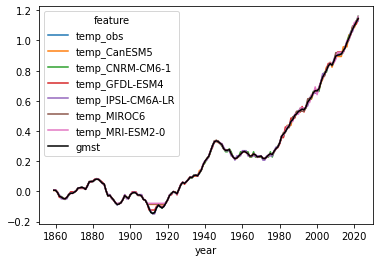

In [22]:
fig,ax=plt.subplots()

df=df_gmt_mapping_ar6_1

temp_cols = [col for col in df.columns if 'temp' in col]
df[temp_cols].plot(ax=ax)
df_gmst_obs_decadal.plot(ax=ax, c='k')

Text(0, 0.5, 'year in models based on GMT-mapping')

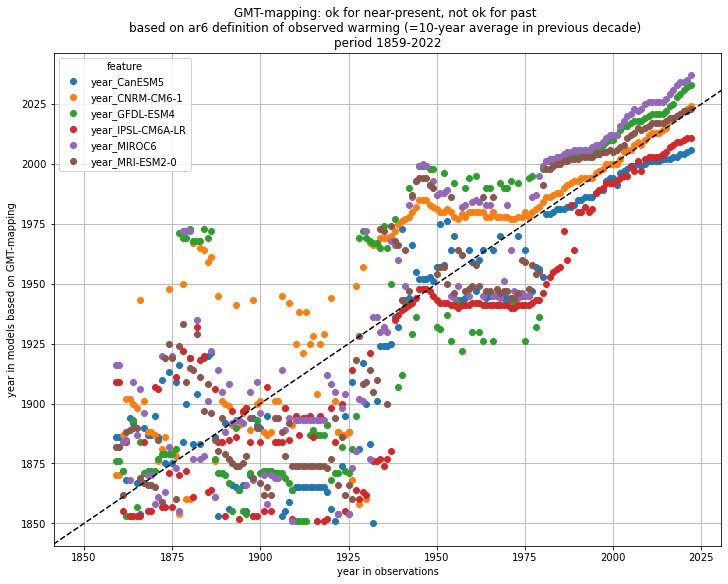

In [58]:
fig,axes=plt.subplots(1,1,figsize=(10,8), sharex=True, layout='constrained')

#ax=axes[0]
ax=axes
df = df_gmt_mapping_ar6_1
year_cols = [col for col in df.columns if 'year' in col]
df[year_cols].plot(ax=ax, marker='o', ls='')
ax.axline((1850,1850), slope=1, ls='--', c='k')
ax.grid()
ax.set_title(f'GMT-mapping: ok for near-present, not ok for past \nbased on ar6 definition of observed warming (=10-year average in previous decade) \nperiod {df.index[0]}-{df.index[-1]}');
plt.xlabel('year in observations')
plt.ylabel('year in models based on GMT-mapping')

# ax=axes[1]
# df = df_gmt_mapping_ar6_10
# year_cols = [col for col in df.columns if 'year' in col]
# df[year_cols].plot(ax=ax, marker='o', ls='')
# ax.axline((1850,1850), slope=1, ls='--', c='k')
# ax.grid()
# ax.set_title('ar6 10-year average min length 10');

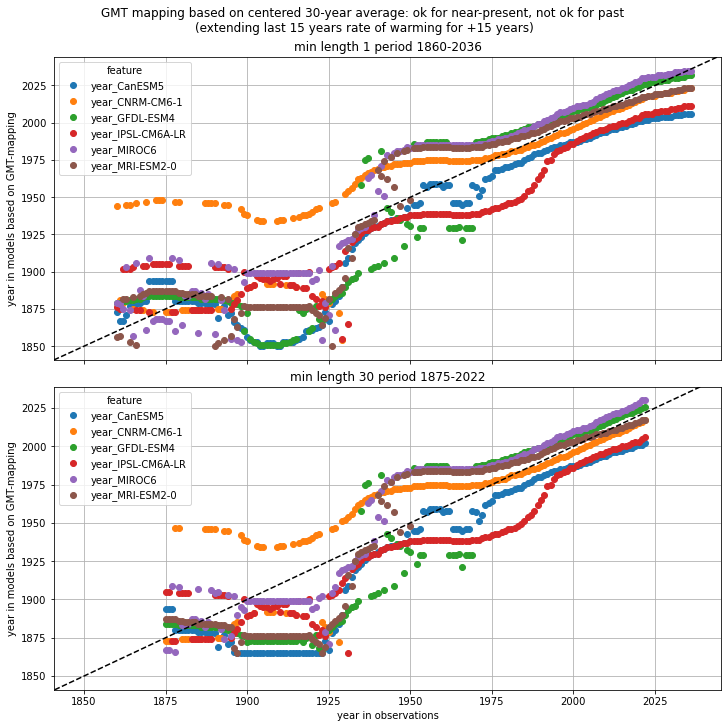

In [62]:
fig,axes=plt.subplots(2,1,figsize=(10,10), sharex=True, layout='constrained')

ax=axes[0]
df = df_gmt_mapping_30y_1
year_cols = [col for col in df.columns if 'year' in col]
df[year_cols].plot(ax=ax, marker='o', ls='')
ax.axline((1850,1850), slope=1, ls='--', c='k')
ax.grid()
ax.set_title(f'min length 1 period {df.index[0]}-{df.index[-1]}');


ax=axes[1]
df = df_gmt_mapping_30y_30
year_cols = [col for col in df.columns if 'year' in col]
df[year_cols].plot(ax=ax, marker='o', ls='')
ax.axline((1850,1850), slope=1, ls='--', c='k')
ax.grid()
ax.set_title(f'min length 30 period {df.index[0]}-{df.index[-1]}');

for ax in axes:
    ax.set_xlabel('year in observations')
    ax.set_ylabel('year in models based on GMT-mapping')
    
fig.suptitle('GMT mapping based on centered 30-year average: ok for near-present, not ok for past? \n(extending last 15 years rate of warming for +15 years)');

# in panel a why does it slow in all models? based on extrapolated GMT values? 

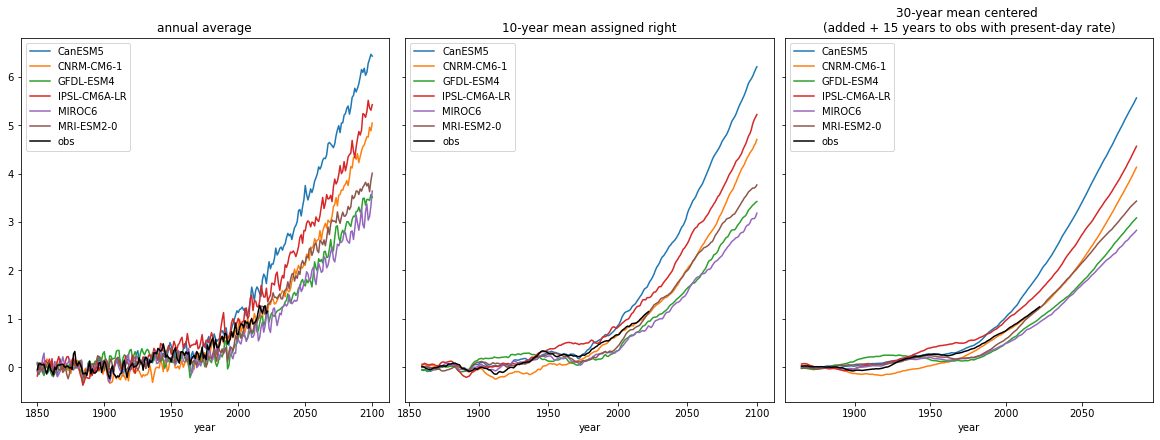

In [65]:
# repeat plots from above s

fig,axes=plt.subplots(1,3,figsize=(16,6), sharey=True, layout='constrained')

ax=axes[0]
df_gmst_mod.plot(ax=ax)
df_gmst_obs_annual['gmst'].plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('annual average')

ax=axes[1]
df_gmst_mod.rolling(10, min_periods=10, center=False).mean().plot(ax=ax)
df_gmst_obs_annual['gmst'].rolling(10, min_periods=10, center=False).mean().plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('10-year mean assigned right')

ax=axes[2]
df_gmst_mod.rolling(30, min_periods=30, center=True).mean().plot(ax=ax)
df_gmst_obs_annual_ext['gmst'].rolling(30, min_periods=30, center=True).mean().plot(ax=ax, c='k', label='obs')
ax.legend()
ax.set_title('30-year mean centered \n(added + 15 years to obs with present-day rate)');
